[Preprocessing](#preproc)

[Analyses univariées + bivariées](#description)
       
[Réaliser une ACP](#pca)

[Utiliser un algorithme de clustering de type Kmeans](#kmeans)

[Modéliser grâce à la régression logistique](#reglog)

# Import des librairies + paramètres

In [1]:
import warnings; warnings.simplefilter('ignore')
from P6_toolbox import *

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import scipy             as sp
import sklearn.metrics   as metrics

# pandas settings
pd.set_option('display.max_row', 110)
pd.set_option('display.max_column', 110)

# matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 20})

# loading dataset
notes = pd.read_csv('./dataset/notes.csv')

# Objectif : Créer un détecteur de faux billets
- [X]Mission 0 : décrire
- [X]Mission 1 : simplifier les données ( ACP )
- [X]Mission 2 : Grouper les billets (K means)
- [X]Mission 3 : Effectuer une régression logistique (SciKit Learn)
- [X]Mission 4 : Tester le détecteur

## Trouver ce qui différencie les vrais des faux avec une faible chance de se tromper

# Preprocessing<a class="anchor" id="preproc"></a>

### Détecter les outliers
- **variable étalonnage** : R² = 0 , 'diagonal'
- **3 critères ordonnés de sélection des billets** :

    - L'effet de levier est une mesure de la distance qui sépare les valeurs de la variable indépendante de celles des autres observations.

    - La distance de Cook mesure l'effet de la suppression d'une valeur dont le résidu est important, impliquant un impact plus important dans la regression.

    - Les résidus studentisés sont les résidus divisé par l'écart-type.

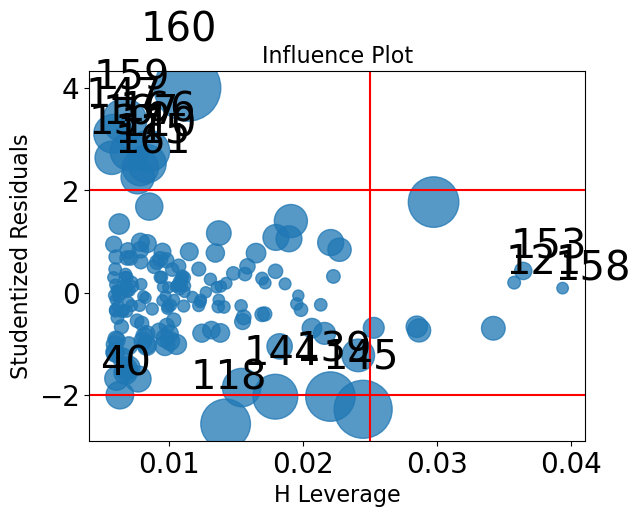

In [2]:
from statsmodels.graphics.regressionplots import influence_plot
import statsmodels.api as sm
import statsmodels.stats as stats

model = sm.OLS(notes['diagonal'], notes[['margin_low', 'length']])
results = model.fit()

influence_plot(results, criterion="cooks")
plt.axhline(y=2, color='r')
plt.axhline(y=-2, color='r')
plt.axvline(x=0.025, color='r')
plt.show()

### Créer un index des outliers

In [3]:
influence = stats.outliers_influence.OLSInfluence(results)
influence = influence.summary_frame()[['cooks_d', 'hat_diag', 'standard_resid']]

# Cook's distance : first filter
cook_distance_filter = influence[influence['cooks_d']>= 0.012].copy()

# standardized residuals : second filter
std_residuals_filter = influence[(influence['standard_resid'] <= -2)|
                                 (influence['standard_resid'] >= 2)].copy()

# H leverage : third filter
h_leverage_filter = influence[influence['hat_diag']>= 0.025]

# outliers filter
outliers = pd.concat([cook_distance_filter, std_residuals_filter, h_leverage_filter])
np.unique(outliers.index)

array([ 40,  69, 110, 115, 116, 117, 118, 121, 131, 134, 135, 137, 139,
       142, 144, 145, 147, 150, 151, 153, 158, 159, 160, 161, 166, 167])

### Analyse univariée des outliers

False    24
True      2
Name: is_genuine, dtype: int64


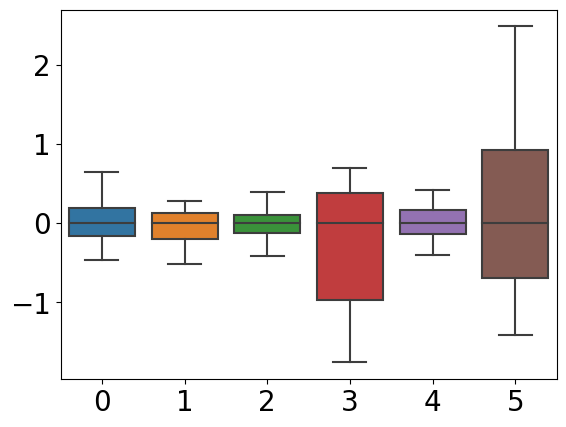

In [4]:
from sklearn.preprocessing import RobustScaler
scaled_outliers = RobustScaler(with_centering=True, with_scaling=False)\
                              .fit_transform(notes.loc[np.unique(outliers.index)])

sns.boxplot(data=scaled_outliers[:, 1:], showfliers=False);
print(notes.loc[np.unique(outliers.index)]['is_genuine'].value_counts())

### Supprimer les outliers

In [5]:
notes = notes.drop(index=np.unique(outliers.index))

# Mission 0 :Analyses univariées + bivariées<a class="anchor" id="description"></a>
Présentation jeu de données 
Présentation brèves analyse bivariées et univariées. (5 minutes)

- RobustScaler : centrer par la médiane, robuste aux outliers.
- pourquoi pas de réduction ? besoin de variance pour détecter les vrais billets des faux.

True     98
False    46
Name: is_genuine, dtype: int64


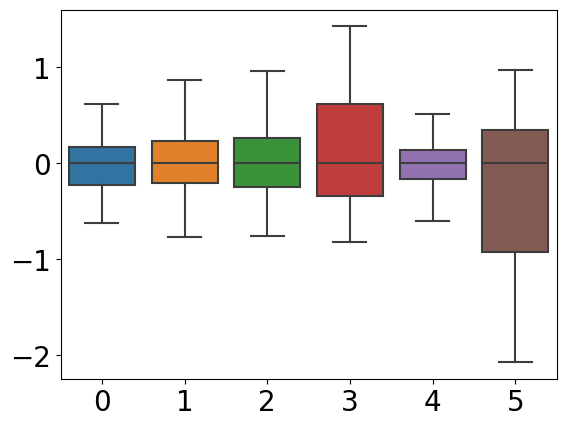

In [6]:
from sklearn.preprocessing import RobustScaler
scaled_notes = RobustScaler(with_centering=True, with_scaling=False).fit_transform(notes)

sns.boxplot(data=scaled_notes[:, 1:], showfliers=False);
print(notes['is_genuine'].value_counts())

### Résultats
- 1, 2 , 3 et 5 : variabilité similaire
- 4 et 6 : grande variabilité quand > 0 pour 4 , quand < 0 pour 6


### Vérification par catégorie pour margin_low et length

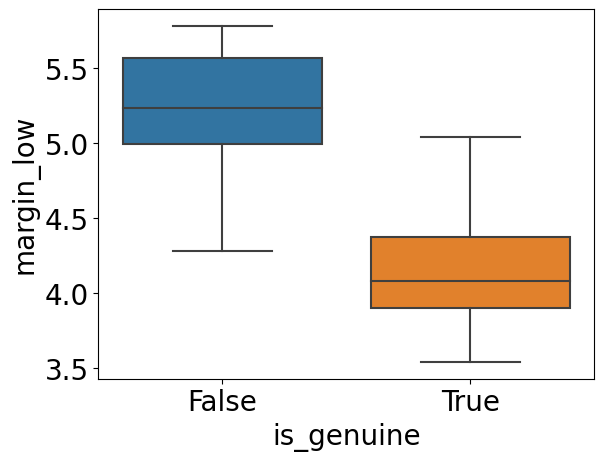

In [7]:
sns.boxplot(x='is_genuine', y='margin_low', data=notes);

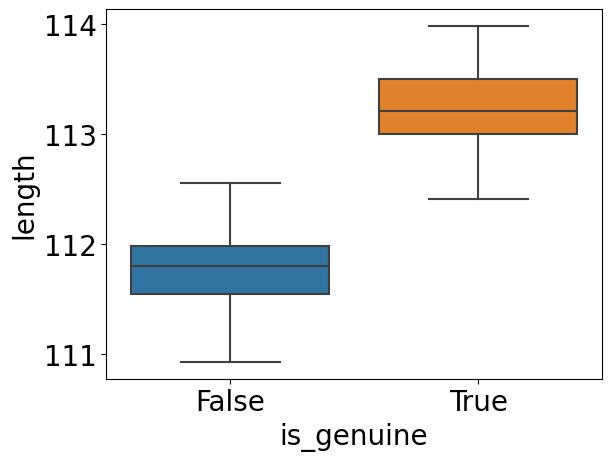

In [8]:
sns.boxplot(x='is_genuine', y='length', data=notes);

### Vérification par test statistique inférentiel

In [9]:
print(ks_shapiro_boolean(notes['margin_low']))
print(ks_shapiro_boolean(notes['length']))

True
True


In [10]:
group_1 = notes[notes['is_genuine']==True]
group_1 = group_1/group_1.std()

group_2 = notes[notes['is_genuine']==False]
group_2 = group_2/group_2.std()

sp.stats.ttest_ind(group_1, group_2)[1][[4,6]]               

array([1.42352306e-009, 7.90361274e-164])

### Résultats
- Les groupes sont statistiquement différents selon les données présentes.

### Analyses bivariées : R² avec 'is_genuine'

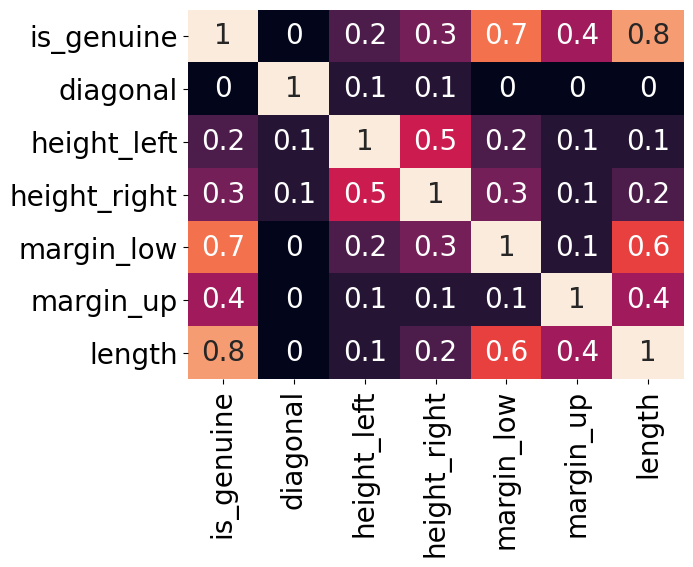

In [11]:
scaled_notes = pd.DataFrame(scaled_notes, columns=notes.columns)

plt.figure(dpi=100)
sns.heatmap((scaled_notes.corr()**2).round(1), cbar=False, annot=True);

### Résultats
- pas de relation linéaire avec 'diagonal': utilisé pour détecter les outliers
- plus forte relation avec 'margin_low' et 'length'

# Réaliser une ACP<a class="anchor" id="pca"></a>
Vous réaliserez une analyse en composantes principales de l'échantillon :

- analyse de l'éboulis des valeurs propres ;
- représentation des variables par le cercle des corrélations ;
- représentation des individus par les plans factoriels ;
- analyser la qualité de la représentation et la contribution des individus.


Pour chacune de ces étapes, commentez les résultats obtenus. 
- La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

### Eboulis des valeurs propres

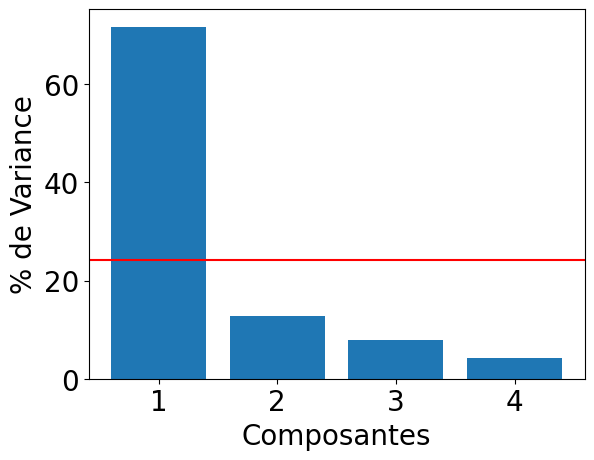

In [12]:
chosen_columns = notes.iloc[:, 1:]

components, pca = pca_transformation(chosen_columns, 0.95)

pca_scree(pca, savefig=False)

### Cercle des corrélations

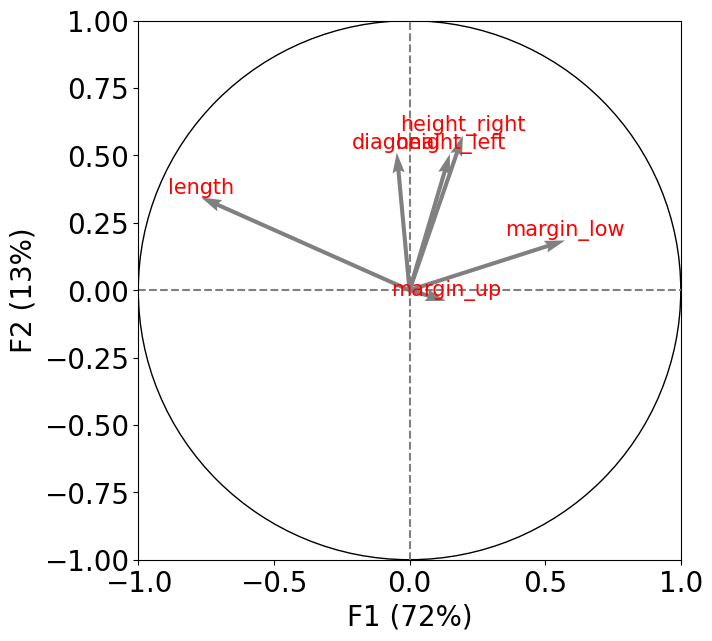

In [13]:
pca_correlation_circle(pca, [1, 2], chosen_columns, savefig=False)

### Résultats : les 3 cas possibles

- **margin_up** n'est pas projetée correctement sur le premier plan factoriel : suppression
- **diagonal** R² = 0 : non corrélé aux données : suppression
- **height_right / height_left** : même variance expliquée car variables corrélées, suppression height_left


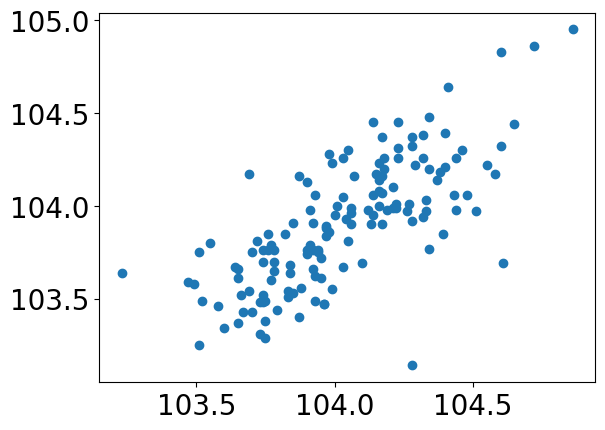

In [14]:
# scatter for checking correlation
plt.scatter(notes['height_left'], notes['height_right']);

### Eboulis des valeurs propres<a class="anchor" id="scree"></a>

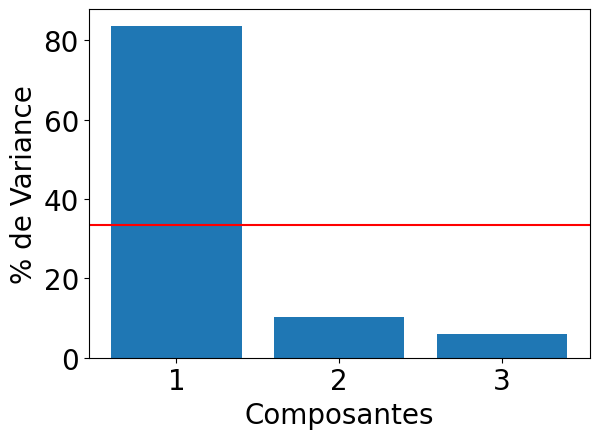

In [15]:
chosen_columns = notes[['length', 'margin_low', 'height_right']]

components, pca = pca_transformation(chosen_columns, 0.95)

pca_scree(pca, savefig=True)

### Cercle des corrélations<a class="anchor" id="circle"></a>

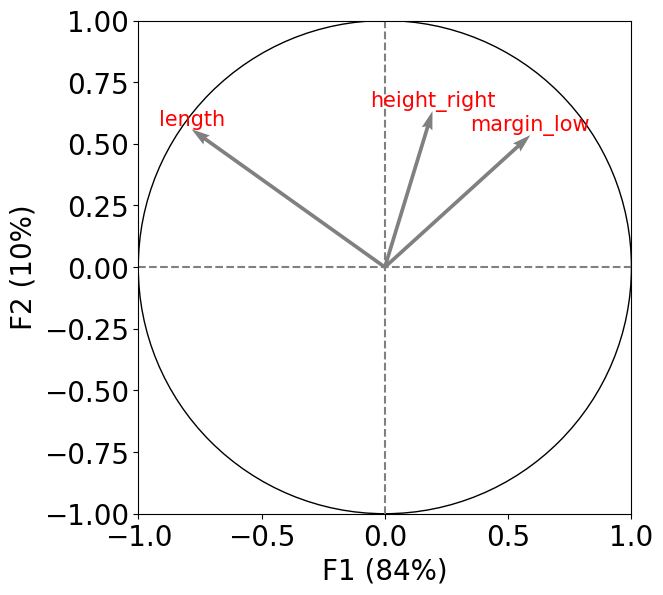

In [16]:
pca_correlation_circle(pca, [1, 2], chosen_columns, savefig=True)

### Premier plan factoriel<a class="anchor" id="factorial"></a>

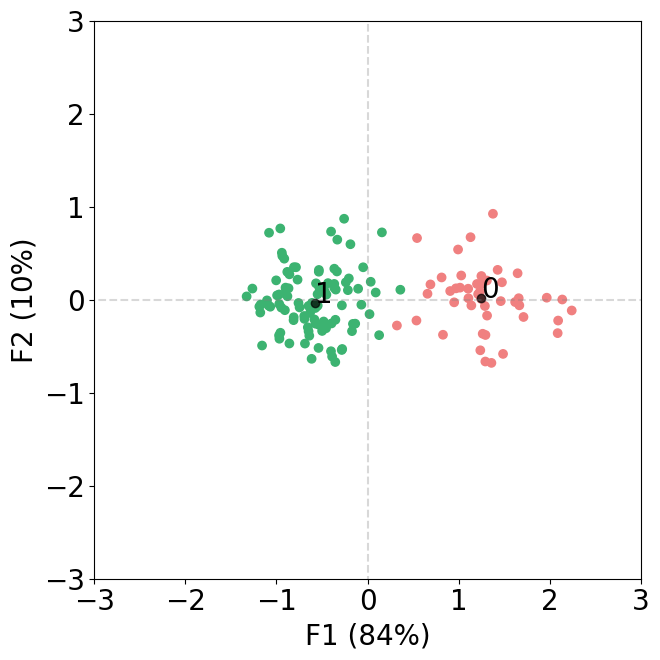

In [17]:
pca_factorial_plane(pca=pca, component_plane=[1, 2], groups=notes['is_genuine'], 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=True)

### Pourquoi ne pas utiliser le plan factoriel 2-3 ?
Parceque les deux groupes se chevauchent, il n'y a pas de différence à exploiter.

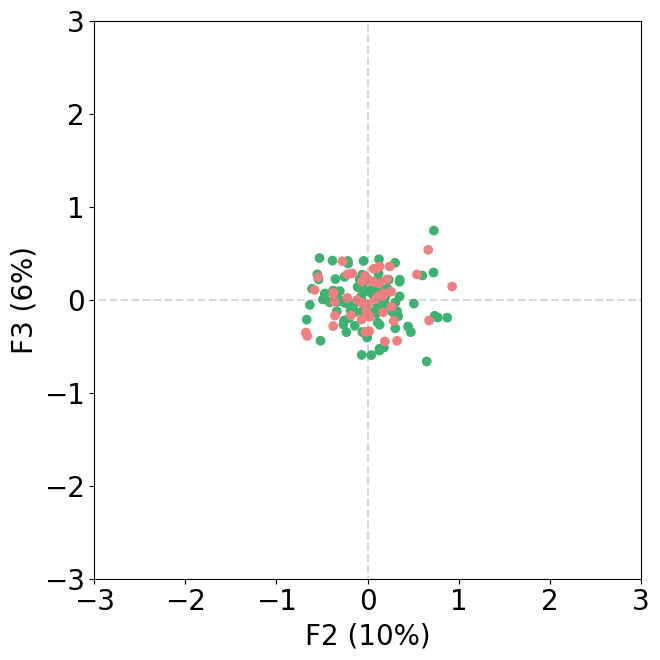

In [18]:
pca_factorial_plane(pca=pca, component_plane=[2, 3], groups=notes['is_genuine'], 
                    columns=chosen_columns,
                    labels=False, centroids=False,
                    savefig=True)

### Créer F1 et F2

In [19]:
components, _ = pca_transformation(chosen_columns, 0.95)
pca_components(components, chosen_columns, notes)

# Utiliser un algorithme de clustering de type Kmeans<a class="anchor" id="kmeans"></a>

### Déterminer le nombre k optimal ( minimisation variance intra-classe )

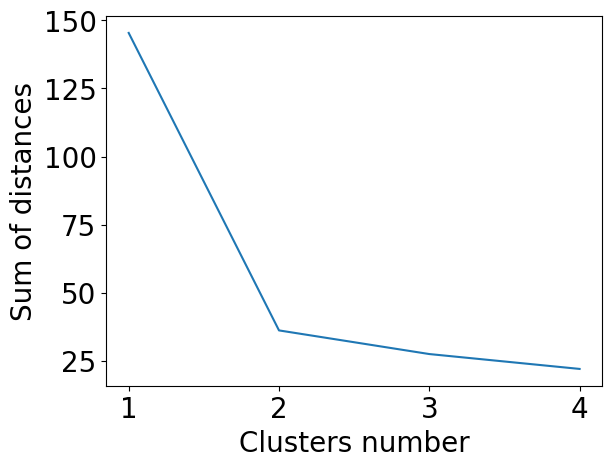

In [20]:
elbow_method_graph(notes[['F1', 'F2']], max_n_clusters=5)

### Utiliser un kmeans

In [21]:
from sklearn.cluster import KMeans

prediction = KMeans(n_clusters=2, random_state=0).fit_predict(notes[['F1', 'F2']])
prediction = np.invert(prediction.astype('bool'))

### Premier plan factoriel

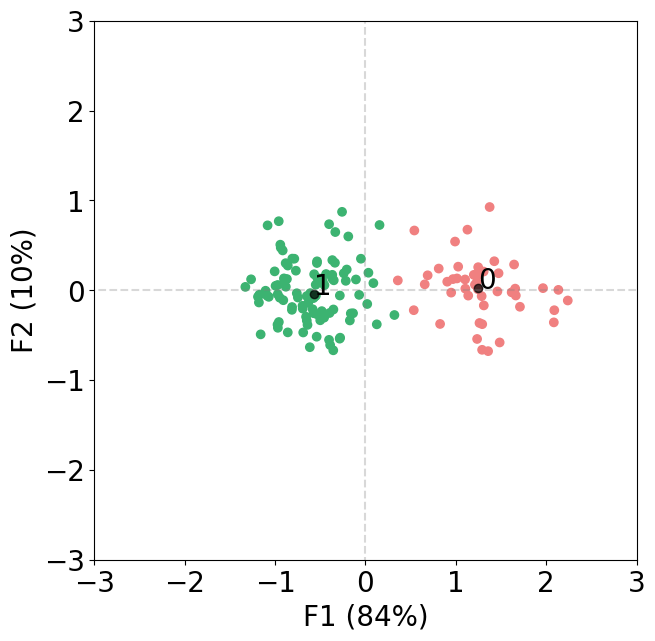

In [22]:
pca_factorial_plane(pca=pca, component_plane=[1, 2], groups=prediction, 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=False)

In [23]:
print(metrics.confusion_matrix(y_true=notes['is_genuine'], y_pred=prediction))
print('AUROC : ', metrics.roc_auc_score(y_true=notes['is_genuine'], y_score=prediction))

[[45  1]
 [ 1 97]]
AUROC :  0.9840283939662822


### Résultats

- 2 points mal classés : 1 Faux Négatif et un Faux Positif

- chaque point mal classé est plus proche de la moyenne de l'autre groupe

- Suppression des 2 points à faire

### KNeighborsClassifier + GridSearchCV

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = notes[['F1', 'F2']]
y = notes['is_genuine']

# GridSearchCV
parameters_dictionnay = {'n_neighbors': np.arange(2, 11)}

grid = GridSearchCV(KNeighborsClassifier(metric='euclidean', 
                                         weights='distance'), parameters_dictionnay, cv=5)
grid.fit(X, y)

# scoring then modelling
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_

# prediction results
prediction = model.predict(X)

{'n_neighbors': 5}
0.993103448275862


### Partition dans le premier plan factoriel

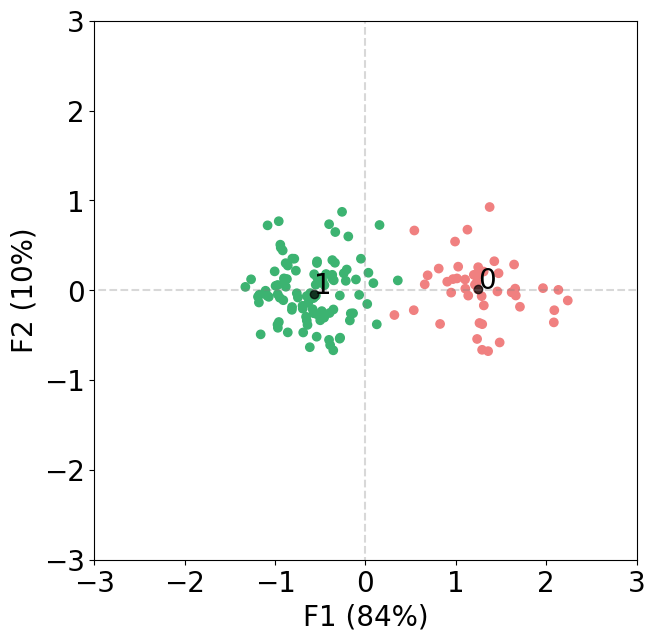

In [25]:
pca_factorial_plane(pca=pca, component_plane=[1, 2], groups=prediction, 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=False)

### Estimer la qualité d'un modèle

In [26]:
confusion_matrix_sens_spec(model, y=notes['is_genuine'], X=notes[['F1', 'F2']])

[[46  0]
 [ 0 98]]
sensitivity + 1.0
specificity - 1.0
AUROC score : 1.0


### Résultats

- Le modèle est bien calibré.
- Cependant, nous utiliserons les outliers du kmeans

In [27]:
# deleting kmeans outliers
notes = notes.drop(index=[9, 102])

# Modéliser grâce à la régression logistique<a class="anchor" id="reglog"></a>
- Modélisez les données à l'aide d'une régression logistique 
- donner la probabilité que le billet soit vrai. Condition Vrai : probabilité >= 0.5

### Test compatibilité loi de Bernoulli
- Hypothèse nulle : les 2 variables sont compatibles avec la loi de Bernoulli ( p = 0.5 )

In [28]:
bernoulli_ks_pvalue(notes['is_genuine'])

1.0

### Résultats
- 'is_genuine' est compatible avec la loi de Bernoulli
- besoin de rendre les classes homogènes  pour la modélisation

# Preprocessing : QuantileTransformer

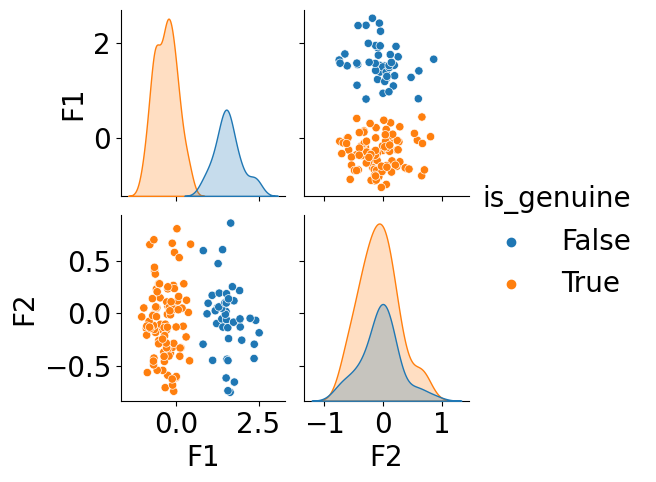

In [29]:
sns.pairplot(notes[['is_genuine', 'F1', 'F2']], hue='is_genuine');

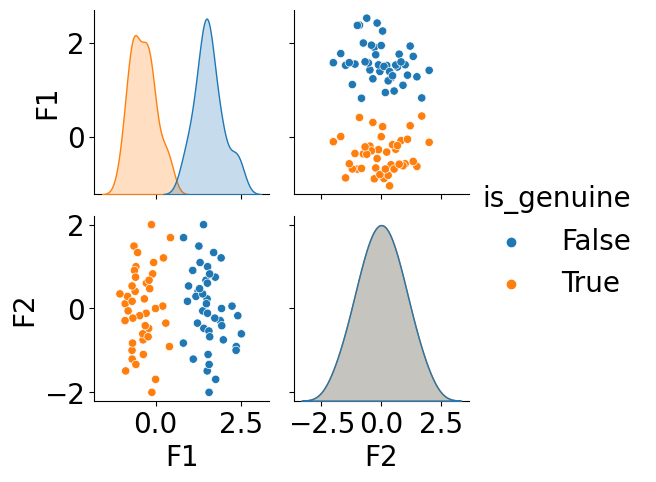

In [30]:
true_notes = notes[notes['is_genuine']==True]
false_notes = notes[notes['is_genuine']==False]

# creating transformer
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(output_distribution='normal')


# equiprobability sampling
notes_true_equal_false_size = np.random.choice(true_notes.index, 
                                               size=false_notes.shape[0], 
                                               replace=False)

notes = pd.concat([notes.loc[notes_true_equal_false_size], false_notes], axis=0)

# applying transformer
true_notes = notes[notes['is_genuine']==True]
false_notes = notes[notes['is_genuine']==False]
notes.loc[true_notes.index, ['F2']] = transformer.fit_transform(notes.loc[true_notes.index, ['F2']])
notes.loc[false_notes.index, ['F2']] = transformer.fit_transform(notes.loc[false_notes.index, ['F2']])

# droping outliers
std_threshold = 3
notes = notes[(notes['F2'] > -std_threshold) & (notes['F2'] < std_threshold)]

# visual result
sns.pairplot(notes[['is_genuine', 'F1', 'F2']], hue='is_genuine');

### Modéliser avec le framework ScikitLearn

In [31]:
model = logistic_regression(y=notes['is_genuine'], X=notes[['F1', 'F2']])

GridSearchCV :  {'class_weight': 'balanced', 'fit_intercept': 'True', 'penalty': 'l1', 'solver': 'liblinear'}
Coefficients :  [[-4.1493511  0.       ]]
Train score (CV 20): 1.0
Test score : 1.0


### Vérification : matrice de confusion + score ROC AUC

In [32]:
confusion_matrix_sens_spec(model, y=notes['is_genuine'], X=notes[['F1', 'F2']])

[[43  0]
 [ 0 43]]
sensitivity + 1.0
specificity - 1.0
AUROC score : 1.0


### Résultats
- Les données sont bien formatées

# Distribuer un modèle : chargement et sauvegarde

In [33]:
from joblib import dump, load
dump(model, './model/normal.model') 
model = load('./model/normal.model')

model

LogisticRegression(class_weight='balanced', fit_intercept='True', penalty='l1',
                   solver='liblinear')